## Step 1
### Download the Kaggle Chest X-ray (Pneumonia) Dataset
- Create a Kaggle account
- Go to the [account](https://www.kaggle.com/udacityinc/account) page.
- Create and download an API token to your personal system.

## Step 2
### Install the Kaggle API \[[Reference](https://www.kaggle.com/docs/api#installation)\]

In [2]:
!pip install kaggle

     |████████████████████████████████| 58 kB 8.1 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 78 kB 1.4 MB/s             
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73275 sha256=81b200490cf604e452d71c0f8e439dba2291f5e87185ce310a5f9d7fe38f8570
  Stored in directory: /home/ec2-user/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle


## Step 3 
### Set up Kaggle API token \[[Reference](https://www.kaggle.com/docs/api#authentication)\]
- Move the Kaggle API token to a directory named `.kaggle` inside the home directory 

Check the directory we are in.

In [3]:
!pwd

/home/ec2-user/SageMaker/sagemaker-deployment


Create the hidden directory.

In [12]:
!mkdir /home/ec2-user/.kaggle

mkdir: cannot create directory ‘/home/ec2-user/.kaggle’: File exists


Check that the direcotry has been created.

In [14]:
!ls -al /home/ec2-user/

total 2924
drwx------ 23 ec2-user ec2-user    4096 Jan 17 21:11 .
drwxr-xr-x  5 root     root        4096 Dec 21 00:48 ..
drwxrwxr-x 27 ec2-user ec2-user    4096 Dec  9 07:57 anaconda3
drwxr-xr-x  2 ec2-user root        4096 Jan 17 20:46 .aws
-rw-r--r--  1 ec2-user ec2-user      18 Jun 16  2020 .bash_logout
-rw-r--r--  1 ec2-user ec2-user     193 Jun 16  2020 .bash_profile
-rw-r--r--  1 ec2-user ec2-user     611 Dec  9 07:50 .bashrc
drwxr-xr-x  4 ec2-user ec2-user    4096 Dec 21 00:43 .cache
drwxrwxr-x  2 ec2-user ec2-user    4096 Dec  9 07:50 .conda
-rw-rw-r--  1 ec2-user ec2-user     148 Dec 21 00:33 .condarc
drwxrwxr-x  5 ec2-user ec2-user    4096 Dec 21 00:49 .config
drwxrwxr-x  8 ec2-user ec2-user    4096 Dec  9 10:29 .dl_binaries
drwxrwxr-x 10 ec2-user ec2-user    4096 Dec  9 07:49 examples
-rw-r--r--  1 ec2-user ec2-user     481 Dec 21 00:49 .gitconfig
drwxr-xr-x  5 ec2-user ec2-user    4096 Jan 17 20:54 .ipython
drwxr-xr-x  4 ec2-user ec2-user    4096 Jan 17 20:50 .jupyter
drwx

From the GUI upload the kaggle.json API token file to the current direcotry 
then move it to the newly created directory

In [16]:
!mv kaggle.json /home/ec2-user/.kaggle/

\[OPTIONAL\]Restrict access rights to the API token.

In [18]:
!chmod 600 /home/ec2-user/.kaggle/kaggle.json

## Step 4
### Set up the dataset in Sagemaker
- Download the [pneumonia dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) using the Kaggle API
- Unzip the dataset

In [21]:
!mkdir ./data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --path ./data

100%|█████████████████████████████████████▉| 2.29G/2.29G [00:27<00:00, 95.0MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [00:27<00:00, 88.4MB/s]


In [26]:
!unzip  -q ./data/chest-xray-pneumonia.zip -d ./data 

## Step 5
### Explore a few data samples
- Look at the direcotry structure of the dataset
- Pay attention to the naming scheme of the image files in the NORMAL and PNEUMONIA sub-directories 
- Plot a few images from the two categories
- Is there a pronounced difference between normal and pneumonia X-rays?
- How large are the images? Is the image size fixed?

In [1]:
from PIL import Image

In [2]:
sample_path = './data/chest_xray/train/NORMAL/IM-0122-0001.jpeg'
sample_image = Image.open(sample_path)

In [3]:
import matplotlib.pyplot as plt

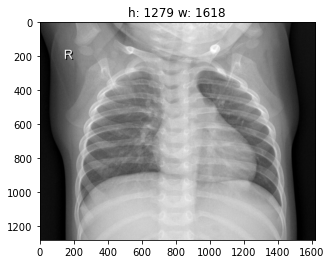

In [4]:
plt.imshow(sample_image,cmap='gray')
plt.title('h: '+str(sample_image.height)+' w: '+str(sample_image.width))
plt.show()

## Step 6
### Create Pytorch dataloaders for training, validation and testing
- Decide data tranformations
- Create Pytorch datasets from the folder structure
- Create dataloaders from the corresponding datasets

In [5]:
data_root = './data/chest_xray/'
train_data_dir = 'train'
test_data_dir = 'test'
val_data_dir = 'val'

In [6]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [37]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

In [38]:
## All normalizations below done using the image net mean and std. deviation
## as described here: https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683/2 

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224,224)),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN,
                         IMAGENET_STD)
])

test_transforms =  transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN,
                         IMAGENET_STD)
])


val_transforms =  transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN,
                         IMAGENET_STD)])

In [39]:
train_dataset = ImageFolder(os.path.join(data_root,train_data_dir),transform=train_transforms)
test_dataset = ImageFolder(os.path.join(data_root,test_data_dir), transform=test_transforms)
val_dataset = ImageFolder(os.path.join(data_root,val_data_dir), transform=val_transforms)
print(train_dataset, test_dataset, val_dataset)

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ./data/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomRotation(degrees=(-5, 5), resample=False, expand=False)
               ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 624
    Root location: ./data/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./data/chest_xray/val
    Stand

In [40]:
from torch.utils.data import DataLoader

In [41]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## Step 7
### Sanity test the data 
- Plot a few random data points

In [46]:
def denormalize(x):
    return x * IMAGENET_STD+IMAGENET_MEAN

def tensor_to_img(t):
    return t.numpy().transpose(1,2,0)

In [47]:
sample_X, sample_y = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


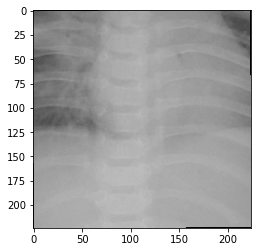

In [50]:
plt.imshow(denormalize(tensor_to_img(sample_X[7])));plt.show()

## Step 8
### Shop around for a model \[[Reference](https://pytorch.org/vision/stable/models.html)\]